Here we will be examining ground motion at South, Pole Antarctica from three co-located seismometers. 

Step 1 will be loading in the packages we will be using and defining where we will get the data from (IRIS)

In [1]:
from obspy.clients.fdsn import Client
from obspy.core import UTCDateTime, Stream
import matplotlib.pyplot as plt
from obspy import read_inventory

client = Client('IRIS')

Now we will grab all the Deep (>200 m depth) sensors at South Pole. Recall that the network is "IU", the station is "QSPA." The sensors based on location code are as follows:

00 -> Geotech KS-54000 Broadband Seismomter 
10 -> Guralp 3T Broadband Seismometer 
85 -> Geotech GS-13 Geophone (what we showed during the lecture)



In [2]:
stime = UTCDateTime('2020-336T20:58:00')
etime = stime + 800.

sncls = [['IU', 'QSPA', '00', 'BHZ'], ['IU', 'QSPA', '10', 'BHZ'],
    ['IU', 'QSPA', '85', 'HHZ']]
st = Stream()
for sncl in sncls:
        # Grabbing data from IRIS
        st += client.get_waveforms(sncl[0], sncl[1], sncl[2], sncl[3],
         stime, etime)


Remove any DC offsets in the data and plot.Use the trim function to zoom in on different portions of the waveform

Are the seismometers seeing the same thing here? What is different? Which location/sensor has the highest sensitivity? 

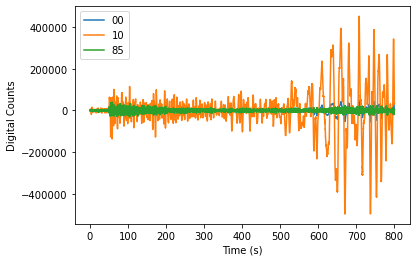

In [3]:
st.detrend('constant')
st_first_plot = st.copy()
# Option you can trim to look at different arrivals if you'd like
#st_first_plot.trim(stime,stime+100)
fig =plt.figure(1)
for tr in st_first_plot:
    plt.plot(tr.times(), tr.data,label=tr.stats.location)
plt.xlabel('Time (s)')
plt.ylabel('Digital Counts')
plt.legend()

Now Grab the Response information from IRIS

In [4]:
for sncl in sncls:
    if 'inv' not in vars():
        inv = client.get_stations(network=sncl[0], station=sncl[1], location= sncl[2], channel=sncl[3],
        starttime=stime, endtime=etime, level='response')
    else:
        inv += client.get_stations(network=sncl[0], station=sncl[1],location= sncl[2], channel=sncl[3],
        starttime=stime, endtime=etime, level='response')

For a Sanity Check- let's look at the inventory object for the GS-13 and plot up the GS-13 Response. You can play around with different levels of the inventory object by deleting "0s" if you wish! 

Does it look like you'd expect? 

Channel 'HHZ', Location '85' 
	Time range: 2011-01-18T00:00:00.000000Z - --
	Latitude: -89.93, Longitude: 144.44, Elevation: 2600.0 m, Local Depth: 250.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 100.00 Hz
	Sensor (Description): None (Geotech GS-13 Seismometer)
	Response information available
Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 9.6836e+10 defined at 5.000 Hz
	4 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 1617
		Stage 2: PolesZerosResponseStage from V to V, gain: 142.78
		Stage 3: CoefficientsTypeResponseStage from V to counts, gain: 419430
		Stage 4: CoefficientsTypeResponseStage from counts to counts, gain: 1


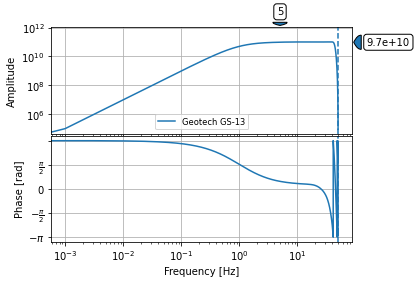

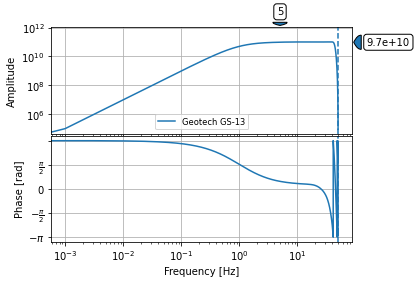

In [5]:
INV_GS13 = inv.select(location='85')
print(INV_GS13[0][0][0])
print(INV_GS13[0][0][0].response)

resp = INV_GS13[0][0][0].response
resp.plot(0.001, output="VEL", label="Geotech GS-13") 


Now let's do the same with the 3T. How is the response different than the geophone (GS13)? 

Based on the Difference in waveforms is this what you would expect? (Hint: what are the dominant frequencies of the Earthquake?) 

Channel 'BHZ', Location '10' 
	Time range: 2011-01-18T00:00:00.000000Z - --
	Latitude: -89.93, Longitude: 144.44, Elevation: 2596.0 m, Local Depth: 254.0 m
	Azimuth: 0.00 degrees from north, clockwise
	Dip: -90.00 degrees down from horizontal
	Channel types: CONTINUOUS, GEOPHYSICAL
	Sampling Rate: 40.00 Hz
	Sensor (Description): None (Guralp CMG3-T Seismometer (borehole))
	Response information available
Channel Response
	From m/s (Velocity in Meters Per Second) to counts (Digital Counts)
	Overall Sensitivity: 3.30042e+10 defined at 0.020 Hz
	3 stages:
		Stage 1: PolesZerosResponseStage from m/s to V, gain: 19672
		Stage 2: CoefficientsTypeResponseStage from V to counts, gain: 1.67772e+06
		Stage 3: CoefficientsTypeResponseStage from counts to counts, gain: 1


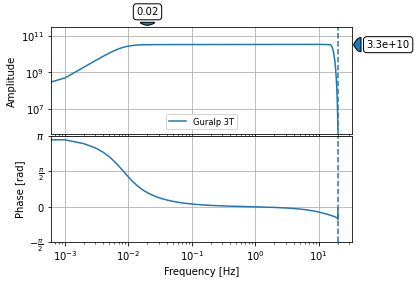

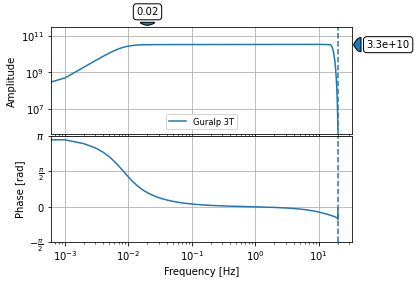

In [6]:
INV_3T = inv.select(location='10')
print(INV_3T[0][0][0])
print(INV_3T[0][0][0].response)

resp = INV_3T[0][0][0].response
resp.plot(0.001, output="VEL", label="Guralp 3T") 

Now we will remove the responses of all the instruments, bandpass filter between 0.01 (100 s) and 10 Hz (0.1 s) and see if we record similar ground velocities or not on all sensors. Which sensor seems the most different? Why do you think that is? 

In [7]:
st.remove_response(inventory=inv)
st.filter('bandpass', freqmin=0.01, freqmax=5, corners=4)

3 Trace(s) in Stream:
IU.QSPA.00.BHZ | 2020-12-01T20:58:00.019538Z - 2020-12-01T21:11:19.969538Z | 20.0 Hz, 16000 samples
IU.QSPA.10.BHZ | 2020-12-01T20:58:00.019538Z - 2020-12-01T21:11:19.994538Z | 40.0 Hz, 32000 samples
IU.QSPA.85.HHZ | 2020-12-01T20:58:00.008393Z - 2020-12-01T21:11:19.998393Z | 100.0 Hz, 80000 samples

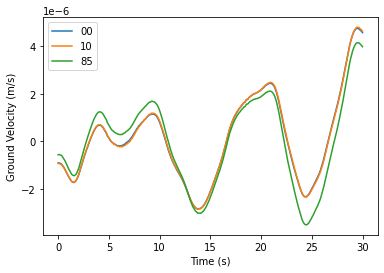

In [13]:
st_secPlot = st.copy()

# Again, have the option to trim to zoom in on different parts of wave form. 
st_secPlot.trim(stime+500,stime+530)


fig =plt.figure(2)
for tr in st_secPlot:
    plt.plot(tr.times(), tr.data,label=tr.stats.location)
plt.xlabel('Time (s)')
plt.ylabel('Ground Velocity (m/s)')
plt.legend()